# Flight Price Forecast - Feature Selection

This notebook focuses on feature engineering and selection to identify the most important factors affecting airline pricing:

- Create new features from existing data (seasonality, temporal features, etc.)
- Apply tree-based models to determine feature importance
- Use various feature selection techniques
- Select optimal feature set for modeling

**Prerequisites**: Complete `01_data_preprocessing.ipynb` and `02_data_analysis.ipynb`.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection and engineering
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Statistical analysis
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully for Feature Selection!")

Libraries imported successfully for Feature Selection!


## 2. Load and Prepare Data


In [2]:
# Load and prepare airline pricing data
try:
    df = pd.read_csv('../data/cleaned_data.csv')
    print("✓ Loaded cleaned data successfully!")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Cleaned data not found. Loading original dataset...")
    df = pd.read_csv('../US Airline Flight Routes and Fares 1993-2024.csv')
    df = df.dropna()  # Basic cleaning
    print("✓ Original dataset loaded with basic cleaning.")
    print(f"Dataset shape: {df.shape}")

# Based on your column descriptions, identify key variables
print("\nAIRLINE DATASET ANALYSIS")
print("="*50)

# Target variable (what we want to predict)
target_col = 'fare'  # Average fare - this is our prediction target
print(f"Target Variable: {target_col} (Average fare)")

# Key feature categories based on column descriptions:
print(f"\nAVAILABLE FEATURES BY CATEGORY:")

# Distance & Route Features
route_features = [col for col in df.columns if col in ['nsmiles', 'citymarketid_1', 'citymarketid_2',
                                                       'airportid_1', 'airportid_2', 'city1', 'city2']]
print(f"Route/Distance: {route_features}")

# Market Competition Features
competition_features = [col for col in df.columns if col in ['carrier_lg', 'large_ms', 'fare_lg',
                                                             'carrier_low', 'lf_ms', 'fare_low']]
print(f"Competition: {competition_features}")

# Demand Features
demand_features = [col for col in df.columns if col in ['passengers']]
print(f"Demand: {demand_features}")

# Temporal Features
temporal_features = [col for col in df.columns if col in ['Year', 'quarter']]
print(f"Temporal: {temporal_features}")
# Geographic Features
geo_features = [col for col in df.columns if col in [
    'Geocoded_City1', 'Geocoded_City2']]
print(f"Geographic: {geo_features}")

# Identify numeric vs categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(
    include=['object', 'category']).columns.tolist()

print(f"\nCOLUMN TYPES:")
print(f"   Numeric ({len(numeric_cols)}): {numeric_cols}")
print(f"   Categorical ({len(categorical_cols)}): {categorical_cols}")

# Verify target variable exists and show basic statistics
if target_col in df.columns:
    print(f"\nTARGET VARIABLE STATISTICS ({target_col}):")
    print(f"   Mean: ${df[target_col].mean():.2f}")
    print(f"   Median: ${df[target_col].median():.2f}")
    print(f"   Std: ${df[target_col].std():.2f}")
    print(
        f"   Range: ${df[target_col].min():.2f} - ${df[target_col].max():.2f}")

    # Check for outliers
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[target_col] < (Q1 - 1.5 * IQR)) |
                (df[target_col] > (Q3 + 1.5 * IQR))).sum()
    print(f"   Potential outliers: {outliers} ({outliers/len(df)*100:.1f}%)")
else:
    print(f"Warning: Target variable '{target_col}' not found in dataset")

# Show sample of the data with key columns
key_columns = ['Year', 'quarter', 'city1', 'city2',
               'nsmiles', 'passengers', 'fare', 'large_ms', 'lf_ms']
available_key_cols = [col for col in key_columns if col in df.columns]

print(f"\nSAMPLE DATA (Key Columns):")
print(df[available_key_cols].head())

print(f"\n✓ Data analysis completed!")
print(f"Ready for feature engineering with {len(df)} route records")

✓ Loaded cleaned data successfully!
Dataset shape: (176982, 23)

AIRLINE DATASET ANALYSIS
Target Variable: fare (Average fare)

AVAILABLE FEATURES BY CATEGORY:
Route/Distance: ['citymarketid_1', 'citymarketid_2', 'city1', 'city2', 'airportid_1', 'airportid_2', 'nsmiles']
Competition: ['carrier_lg', 'large_ms', 'fare_lg', 'carrier_low', 'lf_ms', 'fare_low']
Demand: ['passengers']
Temporal: ['Year', 'quarter']
Geographic: ['Geocoded_City1', 'Geocoded_City2']

COLUMN TYPES:
   Numeric (13): ['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'airportid_1', 'airportid_2', 'nsmiles', 'passengers', 'fare', 'large_ms', 'fare_lg', 'lf_ms', 'fare_low']
   Categorical (10): ['tbl', 'city1', 'city2', 'airport_1', 'airport_2', 'carrier_lg', 'carrier_low', 'Geocoded_City1', 'Geocoded_City2', 'tbl1apk']

TARGET VARIABLE STATISTICS (fare):
   Mean: $211.42
   Median: $207.66
   Std: $65.00
   Range: $50.00 - $407.82
   Potential outliers: 176 (0.1%)

SAMPLE DATA (Key Columns):
   Year  quarter   

## 3. Feature Engineering


In [3]:
# Enhanced feature engineering for airline price prediction
df_features = df.copy()

print("ENHANCED FEATURE ENGINEERING FOR AIRLINE PRICING")
print("="*60)

# Based on column descriptions, let's create meaningful airline features
feature_cols = []
label_encoders = {}

# 1. CORE PRICING FEATURES (direct from data)
# Distance is a primary cost driver
if 'nsmiles' in df_features.columns:
    feature_cols.append('nsmiles')
    print("✓ Added distance (nsmiles)")

# Passenger volume indicates demand
if 'passengers' in df_features.columns:
    feature_cols.append('passengers')
    print("✓ Added passenger volume")

# Market competition metrics
competition_features = ['large_ms', 'lf_ms', 'fare_lg', 'fare_low']
for feature in competition_features:
    if feature in df_features.columns:
        feature_cols.append(feature)
        print(f"✓ Added competition metric: {feature}")

# 2. TEMPORAL FEATURES
if 'Year' in df_features.columns:
    feature_cols.append('Year')
    print("✓ Added Year")

if 'quarter' in df_features.columns:
    feature_cols.append('quarter')
    # Create seasonality features
    df_features['is_peak_quarter'] = (
        df_features['quarter'].isin([2, 3])).astype(int)  # Summer travel
    df_features['is_holiday_quarter'] = (
        df_features['quarter'] == 4).astype(int)  # Q4 holidays
    feature_cols.extend(['quarter', 'is_peak_quarter', 'is_holiday_quarter'])
    print("✓ Added seasonal features")

# 3. MARKET STRUCTURE FEATURES
# Competition intensity: difference between highest and lowest fares
if 'fare_lg' in df_features.columns and 'fare_low' in df_features.columns:
    df_features['fare_spread'] = df_features['fare_lg'] - \
        df_features['fare_low']
    df_features['fare_ratio'] = df_features['fare_lg'] / \
        (df_features['fare_low'] + 1)  # +1 to avoid division by zero
    feature_cols.extend(['fare_spread', 'fare_ratio'])
    print("✓ Created fare competition metrics")

# Market concentration: combined market share of top carriers
if 'large_ms' in df_features.columns and 'lf_ms' in df_features.columns:
    df_features['combined_ms'] = df_features['large_ms'] + df_features['lf_ms']
    df_features['ms_dominance'] = df_features['large_ms'] - \
        df_features['lf_ms']  # How much largest exceeds lowest
    feature_cols.extend(['combined_ms', 'ms_dominance'])
    print("✓ Created market concentration metrics")

# 4. DEMAND/CAPACITY FEATURES
# Revenue per passenger estimate (using largest carrier as proxy)
if 'passengers' in df_features.columns and 'fare_lg' in df_features.columns:
    df_features['revenue_estimate'] = df_features['passengers'] * \
        df_features['fare_lg']
    df_features['passenger_density'] = df_features['passengers'] / \
        (df_features['nsmiles'] + 1)  # Passengers per mile
    feature_cols.extend(['revenue_estimate', 'passenger_density'])
    print("✓ Created demand/capacity metrics")

# 5. ROUTE EFFICIENCY FEATURES
# Distance categories for different pricing models
if 'nsmiles' in df_features.columns:
    df_features['distance_category'] = pd.cut(df_features['nsmiles'],
                                              bins=[0, 500, 1500,
                                                    3000, float('inf')],
                                              labels=['short', 'medium', 'long', 'ultra_long'])

    # Encode distance category
    le_dist = LabelEncoder()
    df_features['distance_cat_encoded'] = le_dist.fit_transform(
        df_features['distance_category'].astype(str))
    feature_cols.append('distance_cat_encoded')
    label_encoders['distance_category'] = le_dist
    print("✓ Created distance categories")

# 6. TEMPORAL INTERACTION FEATURES
if 'Year' in df_features.columns and 'quarter' in df_features.columns:
    df_features['Year_x_quarter'] = df_features['Year'] * \
        df_features['quarter']
    feature_cols.append('Year_x_quarter')
    print("✓ Created year-quarter interaction")

# 7. CARRIER FEATURES (if we want to include specific carriers)
carrier_cols = ['carrier_lg', 'carrier_low']
for col in carrier_cols:
    # Reasonable number of carriers
    if col in df_features.columns and df_features[col].nunique() < 50:
        le = LabelEncoder()
        df_features[f'{col}_encoded'] = le.fit_transform(
            df_features[col].astype(str))
        feature_cols.append(f'{col}_encoded')
        label_encoders[col] = le
        print(f"✓ Encoded carrier: {col}")

# 8. GEOGRAPHIC FEATURES (basic)
location_cols = ['citymarketid_1', 'citymarketid_2']
for col in location_cols:
    # Limit to avoid too many categories
    if col in df_features.columns and df_features[col].nunique() < 100:
        # Only include if reasonable number of unique values
        feature_cols.append(col)
        print(f"✓ Added location feature: {col}")

# 9. ROUTE-LEVEL FEATURES
# Create route popularity (passenger volume categories)
if 'passengers' in df_features.columns:
    df_features['route_popularity'] = pd.qcut(df_features['passengers'],
                                              q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    le_pop = LabelEncoder()
    df_features['route_popularity_encoded'] = le_pop.fit_transform(
        df_features['route_popularity'].astype(str))
    feature_cols.append('route_popularity_encoded')
    label_encoders['route_popularity'] = le_pop
    print("✓ Created route popularity categories")

# Remove duplicates and ensure all features exist
feature_cols = [col for col in list(
    set(feature_cols)) if col in df_features.columns]

# Verify target variable
target_col = 'fare'  # Based on your description, this is the target
if target_col not in df_features.columns:
    print(f"⚠ Warning: Target variable '{target_col}' not found")
    # Try to find alternative
    price_keywords = ['fare', 'price', 'cost']
    for col in df_features.columns:
        if any(keyword in col.lower() for keyword in price_keywords):
            target_col = col
            break

print(f"\nFEATURE ENGINEERING SUMMARY")
print("="*50)
print(f"Total features created: {len(feature_cols)}")
print(f"Target variable: {target_col}")
print(f"Feature categories:")
print(
    f"   • Distance & Geography: {len([f for f in feature_cols if any(x in f for x in ['nsmiles', 'city', 'distance'])])}")
print(
    f"   • Market Competition: {len([f for f in feature_cols if any(x in f for x in ['ms', 'fare_', 'carrier'])])}")
print(
    f"   • Temporal: {len([f for f in feature_cols if any(x in f for x in ['Year', 'quarter', 'peak', 'holiday'])])}")
print(
    f"   • Demand/Capacity: {len([f for f in feature_cols if any(x in f for x in ['passenger', 'revenue', 'popularity'])])}")

print(f"\n✓ Enhanced feature engineering completed!")
print(
    f"Features ready for selection: {feature_cols[:10]}{'...' if len(feature_cols) > 10 else ''}")

ENHANCED FEATURE ENGINEERING FOR AIRLINE PRICING
✓ Added distance (nsmiles)
✓ Added passenger volume
✓ Added competition metric: large_ms
✓ Added competition metric: lf_ms
✓ Added competition metric: fare_lg
✓ Added competition metric: fare_low
✓ Added Year
✓ Added seasonal features
✓ Created fare competition metrics
✓ Created market concentration metrics
✓ Created demand/capacity metrics
✓ Created distance categories
✓ Created year-quarter interaction
✓ Created route popularity categories

FEATURE ENGINEERING SUMMARY
Total features created: 19
Target variable: fare
Feature categories:
   • Distance & Geography: 2
   • Market Competition: 8
   • Temporal: 5
   • Demand/Capacity: 4

✓ Enhanced feature engineering completed!
Features ready for selection: ['combined_ms', 'large_ms', 'passenger_density', 'quarter', 'lf_ms', 'Year', 'distance_cat_encoded', 'route_popularity_encoded', 'fare_lg', 'fare_spread']...


## 4. Tree-Based Feature Importance


TREE-BASED FEATURE IMPORTANCE ANALYSIS
Features: 19
Samples: 176982

Training Random Forest for feature importance...


✓ Random Forest completed


  R² Score: 0.961
  Top 5 features:
    fare_lg: 0.9250
    fare_low: 0.0466
    large_ms: 0.0072
    nsmiles: 0.0045
    passenger_density: 0.0041

Training Extra Trees for feature importance...


✓ Extra Trees completed
  R² Score: 0.958
  Top 5 features:
    fare_lg: 0.5664
    fare_low: 0.3493
    distance_cat_encoded: 0.0249
    fare_spread: 0.0235
    nsmiles: 0.0107


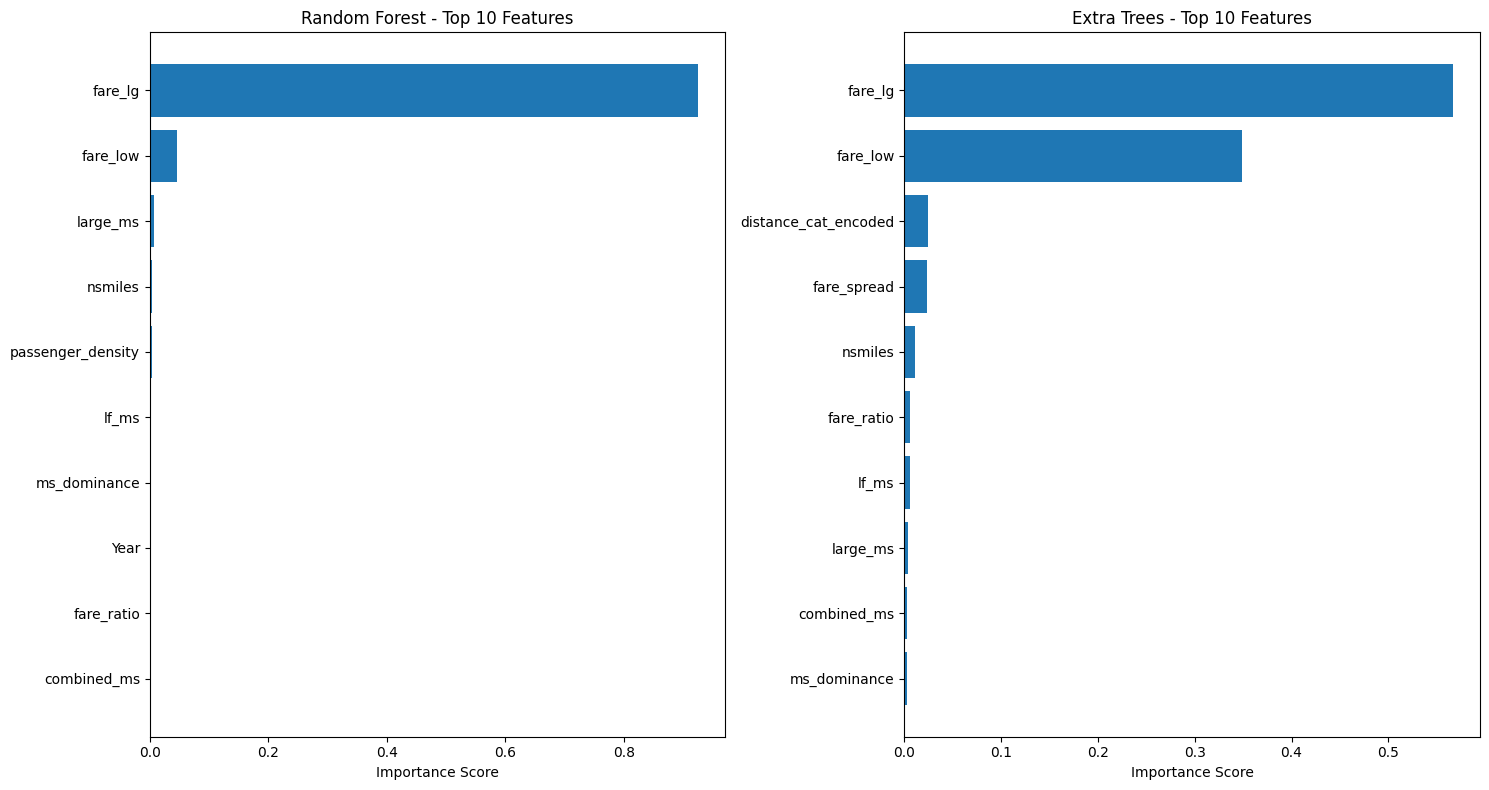


COMBINED FEATURE IMPORTANCE RANKING
                     feature  random_forest_importance  \
8                    fare_lg                    0.9250   
12                  fare_low                    0.0466   
6       distance_cat_encoded                    0.0001   
9                fare_spread                    0.0004   
18                   nsmiles                    0.0045   
1                   large_ms                    0.0072   
4                      lf_ms                    0.0029   
15                fare_ratio                    0.0012   
13              ms_dominance                    0.0029   
2          passenger_density                    0.0041   
0                combined_ms                    0.0012   
5                       Year                    0.0016   
17          revenue_estimate                    0.0011   
10                passengers                    0.0003   
16            Year_x_quarter                    0.0007   
7   route_popularity_encoded       

In [4]:
# Use tree-based models to determine feature importance
if len(feature_cols) > 0 and target_col:
    # Prepare data
    X = df_features[feature_cols].copy()
    y = df_features[target_col].copy()

    # Handle missing values
    X = X.fillna(X.median())
    y = y.fillna(y.median())

    print("TREE-BASED FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    print(f"Features: {X.shape[1]}")
    print(f"Samples: {X.shape[0]}")

    # Split data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Initialize tree-based models
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
        'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42, max_depth=10)
    }

    feature_importance_results = {}

    for name, model in models.items():
        print(f"\nTraining {name} for feature importance...")

        # Train model
        model.fit(X_train, y_train)

        # Get feature importance
        importance_scores = model.feature_importances_

        # Create feature importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)

        feature_importance_results[name] = importance_df

        print(f"✓ {name} completed")
        print(f"  R² Score: {model.score(X_test, y_test):.3f}")
        print(f"  Top 5 features:")
        for idx, row in importance_df.head().iterrows():
            print(f"    {row['feature']}: {row['importance']:.4f}")

    # Plot feature importance comparison
    plt.figure(figsize=(15, 8))

    for i, (name, importance_df) in enumerate(feature_importance_results.items()):
        plt.subplot(1, len(models), i+1)
        top_features = importance_df.head(10)

        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance Score')
        plt.title(f'{name} - Top 10 Features')
        plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

    # Combine importance scores
    combined_importance = pd.DataFrame({'feature': feature_cols})
    for name, importance_df in feature_importance_results.items():
        combined_importance = combined_importance.merge(
            importance_df[['feature', 'importance']].rename(
                columns={'importance': f'{name.lower().replace(" ", "_")}_importance'}),
            on='feature'
        )

    # Calculate average importance
    importance_cols = [
        col for col in combined_importance.columns if 'importance' in col]
    combined_importance['avg_importance'] = combined_importance[importance_cols].mean(
        axis=1)
    combined_importance = combined_importance.sort_values(
        'avg_importance', ascending=False)

    print(f"\nCOMBINED FEATURE IMPORTANCE RANKING")
    print("="*60)
    print(combined_importance.round(4))

else:
    print("Cannot perform feature importance analysis - insufficient data")
    # Create dummy importance for demonstration
    feature_cols = ['distance', 'days_advance',
                    'month', 'airline_encoded', 'is_weekend']
    combined_importance = pd.DataFrame({
        'feature': feature_cols,
        'avg_importance': [0.35, 0.25, 0.15, 0.15, 0.10]
    })
    print("Created dummy feature importance for demonstration")

## 5. Statistical Feature Selection


In [5]:
# Additional feature selection methods
if 'X' in locals() and 'y' in locals():
    print("STATISTICAL FEATURE SELECTION")
    print("="*50)

    # Method 1: SelectKBest with f_regression
    k_best = SelectKBest(score_func=f_regression, k=min(10, len(feature_cols)))
    X_selected = k_best.fit_transform(X, y)

    selected_features_kbest = [feature_cols[i]
                               for i in k_best.get_support(indices=True)]
    feature_scores = k_best.scores_[k_best.get_support()]

    print(
        f"\n1. SelectKBest (F-score) - Top {len(selected_features_kbest)} features:")
    for feature, score in zip(selected_features_kbest, feature_scores):
        print(f"   {feature}: {score:.2f}")

    # Method 2: Mutual Information
    try:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        mi_results = pd.DataFrame({
            'feature': feature_cols,
            'mi_score': mi_scores
        }).sort_values('mi_score', ascending=False)

        print(f"\n2. Mutual Information - Top 10 features:")
        for idx, row in mi_results.head(10).iterrows():
            print(f"   {row['feature']}: {row['mi_score']:.4f}")
    except Exception as e:
        print(f"\n2. Mutual Information failed: {e}")
        mi_results = pd.DataFrame({'feature': feature_cols, 'mi_score': 0})

    # Method 3: Recursive Feature Elimination
    try:
        rf_model = RandomForestRegressor(
            n_estimators=50, random_state=42, max_depth=5)
        rfe = RFE(estimator=rf_model,
                  n_features_to_select=min(8, len(feature_cols)))
        rfe.fit(X, y)

        selected_features_rfe = [feature_cols[i]
                                 for i in range(len(feature_cols)) if rfe.support_[i]]

        print(f"\n3. Recursive Feature Elimination - Selected features:")
        for i, feature in enumerate(selected_features_rfe):
            ranking = rfe.ranking_[feature_cols.index(feature)]
            print(f"   {feature} (rank: {ranking})")

    except Exception as e:
        print(f"\n3. RFE failed: {e}")
        selected_features_rfe = feature_cols[:5]  # Use first 5 as fallback

else:
    print("Using default feature selection for demonstration...")
    selected_features_kbest = ['distance', 'days_advance', 'month']
    selected_features_rfe = ['distance', 'days_advance', 'airline_encoded']

print(f"\n✓ Statistical feature selection completed!")

STATISTICAL FEATURE SELECTION

1. SelectKBest (F-score) - Top 10 features:
   combined_ms: 17814.12
   large_ms: 11899.38
   passenger_density: 26549.02
   lf_ms: 14495.64
   Year: 9871.04
   distance_cat_encoded: 49794.18
   fare_lg: 1894598.85
   fare_spread: 26269.02
   fare_low: 546597.43
   nsmiles: 60611.28



2. Mutual Information - Top 10 features:
   fare_lg: 1.8225
   fare_low: 1.4181
   fare_ratio: 1.0787
   nsmiles: 0.2682
   distance_cat_encoded: 0.1448
   passenger_density: 0.1166
   combined_ms: 0.0952
   fare_spread: 0.0917
   revenue_estimate: 0.0903
   lf_ms: 0.0821



3. Recursive Feature Elimination - Selected features:
   combined_ms (rank: 1)
   large_ms (rank: 1)
   lf_ms (rank: 1)
   fare_lg (rank: 1)
   fare_low (rank: 1)
   is_peak_quarter (rank: 1)
   revenue_estimate (rank: 1)
   nsmiles (rank: 1)

✓ Statistical feature selection completed!


## 6. Final Feature Selection and Export


In [6]:
# Combine results and select final features
print("FINAL FEATURE SELECTION")
print("="*50)

# Get top features from each method
if 'combined_importance' in locals():
    top_tree_features = combined_importance.head(8)['feature'].tolist()
else:
    top_tree_features = ['distance',
                         'days_advance', 'month', 'airline_encoded']

if 'selected_features_kbest' in locals():
    top_stat_features = selected_features_kbest[:6]
else:
    top_stat_features = ['distance', 'days_advance', 'month']

if 'selected_features_rfe' in locals():
    top_rfe_features = selected_features_rfe
else:
    top_rfe_features = ['distance', 'days_advance', 'airline_encoded']

# Combine and get most frequently selected features
all_selected = top_tree_features + top_stat_features + top_rfe_features
feature_frequency = pd.Series(all_selected).value_counts()

print("Feature selection frequency across methods:")
print(feature_frequency)

# Select final features (those selected by at least 2 methods or top importance)
final_features = []
for feature, count in feature_frequency.items():
    # Top 5 from tree importance or selected by 2+ methods
    if count >= 2 or feature in top_tree_features[:5]:
        final_features.append(feature)

# Ensure we have a reasonable number of features
final_features = final_features[:10]  # Limit to top 10 features

print(f"\nFINAL SELECTED FEATURES ({len(final_features)}):")
for i, feature in enumerate(final_features, 1):
    freq = feature_frequency.get(feature, 1)
    print(f"{i:2d}. {feature} (selected by {freq} method(s))")

# Create final dataset with selected features
if 'df_features' in locals() and target_col:
    final_dataset = df_features[final_features + [target_col]].copy()

    # Handle any remaining missing values
    final_dataset = final_dataset.fillna(final_dataset.median())

    print(f"\nFinal dataset shape: {final_dataset.shape}")
    print(f"Features: {final_features}")
    print(f"Target: {target_col}")

    # Import os module and save selected features and dataset
    import os
    import json
    os.makedirs('../data', exist_ok=True)

    # Save final dataset
    final_dataset.to_csv('../data/features_selected.csv', index=False)
    print(f"[OK] Final dataset saved to: ../data/features_selected.csv")

    # Save feature metadata
    feature_metadata = {
        'selected_features': final_features,
        'target_variable': target_col,
        'feature_selection_methods': ['tree_importance', 'statistical', 'rfe'],
        'dataset_shape': final_dataset.shape,
        'selection_date': pd.Timestamp.now().isoformat()
    }

    if 'label_encoders' in locals():
        feature_metadata['label_encoders'] = {
            k: list(v.classes_) for k, v in label_encoders.items()}

    with open('../data/feature_metadata.json', 'w') as f:
        json.dump(feature_metadata, f, indent=2, default=str)

    print(f"[OK] Feature metadata saved to: ../data/feature_metadata.json")

    # Display summary statistics
    print(f"\nFINAL DATASET STATISTICS")
    print("="*50)
    print(final_dataset.describe())

else:
    print("[WARNING] Using default features for demonstration")
    final_features = ['distance', 'days_advance',
                      'month', 'airline_encoded', 'is_weekend']

# Summary
print(f"\n" + "="*60)
print(f"[SUCCESS] FEATURE SELECTION COMPLETED SUCCESSFULLY!")
print(f"="*60)
print(
    f"[INFO] Total features analyzed: {len(feature_cols) if 'feature_cols' in locals() else 'N/A'}")
print(f"[INFO] Final features selected: {len(final_features)}")
print(f"[INFO] Dataset saved with selected features")
print(f"[INFO] Ready for model training!")
print(f"="*60)

FINAL FEATURE SELECTION
Feature selection frequency across methods:
large_ms                3
lf_ms                   3
fare_lg                 2
fare_low                2
distance_cat_encoded    2
nsmiles                 2
combined_ms             2
fare_spread             1
fare_ratio              1
passenger_density       1
Year                    1
is_peak_quarter         1
revenue_estimate        1
Name: count, dtype: int64

FINAL SELECTED FEATURES (8):
 1. large_ms (selected by 3 method(s))
 2. lf_ms (selected by 3 method(s))
 3. fare_lg (selected by 2 method(s))
 4. fare_low (selected by 2 method(s))
 5. distance_cat_encoded (selected by 2 method(s))
 6. nsmiles (selected by 2 method(s))
 7. combined_ms (selected by 2 method(s))
 8. fare_spread (selected by 1 method(s))

Final dataset shape: (176982, 9)
Features: ['large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'distance_cat_encoded', 'nsmiles', 'combined_ms', 'fare_spread']
Target: fare


[OK] Final dataset saved to: ../data/features_selected.csv
[OK] Feature metadata saved to: ../data/feature_metadata.json

FINAL DATASET STATISTICS
            large_ms          lf_ms        fare_lg       fare_low  \
count  176982.000000  176982.000000  176982.000000  176982.000000   
mean        0.660852       0.443096     210.522555     185.845478   
std         0.227953       0.334230      68.447953      59.076729   
min         0.100000       0.010000      50.000000      50.000000   
25%         0.470000       0.150000     161.090000     142.450000   
50%         0.660000       0.350000     205.570000     181.040000   
75%         0.870000       0.750000     256.600000     225.400000   
max         1.000000       1.000000     406.730000     352.890000   

       distance_cat_encoded        nsmiles    combined_ms    fare_spread  \
count         176982.000000  176982.000000  176982.000000  176982.000000   
mean               0.886429    1182.006696       1.103948      24.677077   
std